    Exploring the Data

In [5]:
import pandas as pd 
import numpy as np
import json
import seaborn as sb 
from sklearn.metrics import log_loss
from sklearn import linear_model 
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline

In [87]:
from bs4 import BeautifulSoup
import re
import nltk
from string import ascii_letters
from sklearn.feature_extraction.text import TfidfTransformer

Function to calculate log loss

In [6]:
import math
def logloss(probs, ground_truths):
    # vector of probailities 
    pairings = zip(probs, ground_truths)
    total_loss = 0
    for predictions, label in pairings:
        if label == '1':
            total_loss += math.log(predictions[0]) 
        elif label == '2': 
            total_loss += math.log(predictions[1])
        else:
            total_loss += math.log(predictions[2])
    return float(total_loss)/float(len(ground_truths))
            

In [7]:
df = pd.read_json('data/train.json')
df.head()
len(df)

49352

Number of training rows = 49532 

In [4]:
print 'Number of unique created cols = ' , len(df['created'].unique())

Number of unique created cols =  48675


In [5]:
print df.columns 

Index([u'bathrooms', u'bedrooms', u'building_id', u'created', u'description',
       u'display_address', u'features', u'interest_level', u'latitude',
       u'listing_id', u'longitude', u'manager_id', u'photos', u'price',
       u'street_address'],
      dtype='object')


In [6]:
print 'max price = ' , np.max(df['price'])
print 'min price = ' , np.min(df['price'])

df['price'].describe()

max price =  4490000
min price =  43


count    4.935200e+04
mean     3.830174e+03
std      2.206687e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64

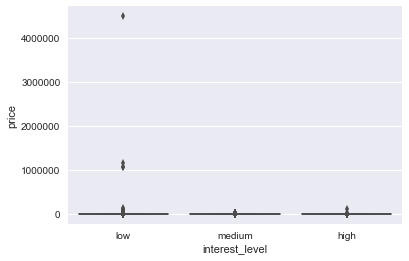

In [7]:
sb.boxplot(x="interest_level", y="price", data=df, order = ['low', 'medium', 'high'])

In [8]:
df = df[df['price'] <= 60000]
# Removing the outliers in the prices 

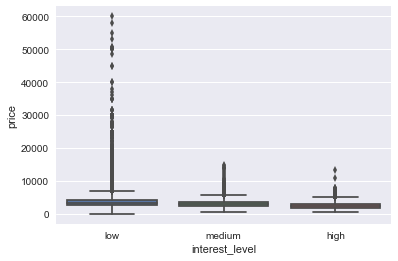

In [9]:
sb.boxplot(x="interest_level", y="price", data=df, order = ['low', 'medium', 'high'])

Index([u'bathrooms', u'bedrooms', u'building_id', u'created', u'description',
       u'display_address', u'features', u'interest_level', u'latitude',
       u'listing_id', u'longitude', u'manager_id', u'photos', u'price',
       u'street_address'],
      dtype='object')


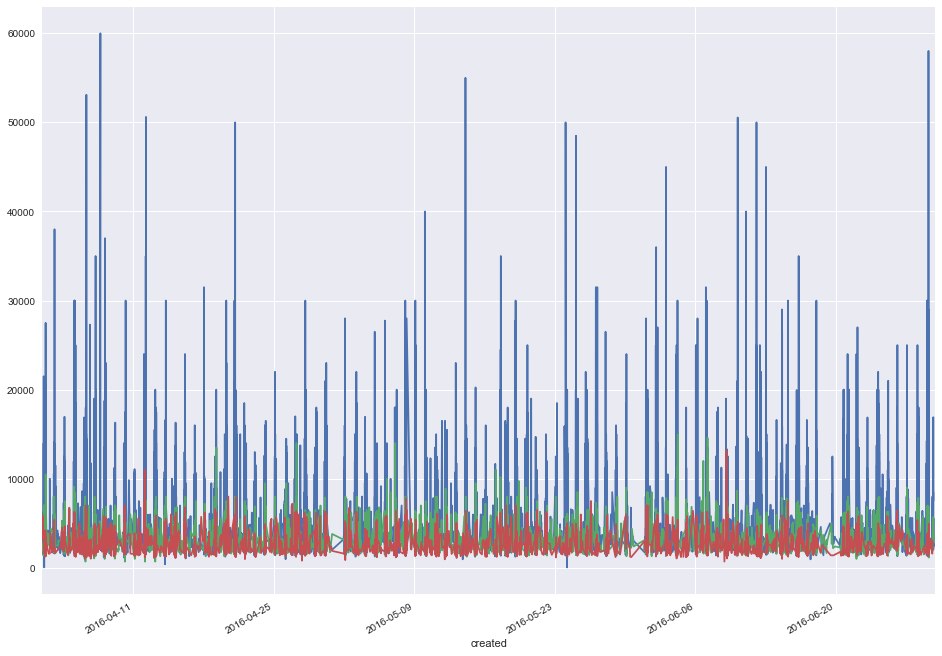

In [10]:
print df.columns
df['created'] = pd.to_datetime(df['created'])
df_chart = df.sort_values(by= 'created')
df_chart.set_index('created', inplace = True)
df_chart[df_chart['interest_level'] == 'low']['price'].plot(figsize=(16, 12))
df_chart[df_chart['interest_level'] == 'medium']['price'].plot(figsize=(16, 12))
df_chart[df_chart['interest_level'] == 'high']['price'].plot(figsize=(16, 12))

In [11]:
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


## Drop columns : created, description, features, building id, photos, 
## Split train test into 80/20 
## Drop rows that have prices with low interest above 60k (outliers)

In [12]:
print df.index
df_new = df.drop(['photos', 'created', 'description', 'features', 'building_id', 'listing_id'], axis = 1)

Int64Index([    10,  10000, 100004, 100007, 100013, 100014, 100016, 100020,
            100026, 100027,
            ...
             99982,  99984,  99986,  99987,  99988,   9999,  99991,  99992,
             99993,  99994],
           dtype='int64', length=49342)


In [13]:
df_new.head()

,bathrooms,bedrooms,display_address,interest_level,latitude,longitude,manager_id,price,street_address
10,1.5,3,Metropolitan Avenue,medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000,792 Metropolitan Avenue
10000,1.0,2,Columbus Avenue,low,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,5465,808 Columbus Avenue
100004,1.0,1,W 13 Street,high,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,2850,241 W 13 Street
100007,1.0,1,East 49th Street,low,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,3275,333 East 49th Street
100013,1.0,4,West 143rd Street,low,40.8241,-73.9493,98e13ad4b495b9613cef886d79a6291f,3350,500 West 143rd Street


## Plot of interest Levels 

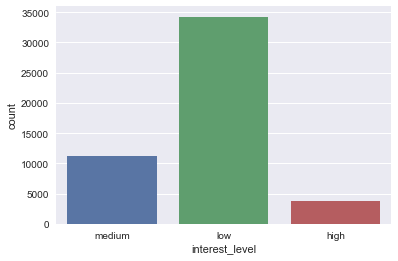

In [14]:
sb.countplot(df['interest_level'])

## Select columns with only int: bathroom, bedrooms, latitude, long, price 
## Split train test into 80/20 
## Drop rows that have prices with low interest above 60k (outliers)

In [15]:
def modify_labels(label):
    if label == 'low':
        return '1'
    elif label == 'medium':
        return '2'
    else:
        return '3'

In [72]:
def tokenizer(string):
    #string = re.sub('^[\w]', '', string)
    tokens = nltk.word_tokenize(string)
    cleaned = [x if not x.isdigit() else '_NUM_' for x in tokens]
    return [x for x in cleaned if (x.isalpha() or x == '_NUM_')]
    

In [78]:
df['description'] = df['description'].apply(clean_html_tags)

D:\Anaconda2\lib\site-packages\bs4\__init__.py:219: UserWarning: "." looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


In [92]:
#Only int 
df_new = df[['bathrooms', 'bedrooms', 'interest_level', 'latitude', 'longitude', 'price', 'description']]
#df_new = df[['bathrooms', 'bedrooms', 'interest_level']]
df_new['interest_level'] = df_new['interest_level'].apply(modify_labels)
df_new.head()
df_new['interest_level'].unique()

NameError: name 'modify_labels' is not defined

In [80]:
count_vect = CountVectorizer(tokenizer = tokenizer, stop_words = 'english')
document_mtrx = count_vect.fit_transform(df['description'])

In [17]:
df_new_target = df_new['interest_level']
df_new = df_new.drop(['interest_level'], axis = 1)
df_new.head()
numeric_cols = df_new.select_dtypes(include=[np.number]).columns
df_new[numeric_cols] = df_new[numeric_cols].apply(zscore)

In [18]:
skf = StratifiedKFold(n_splits=5)

In [29]:
for train_index, test_index in skf.split(df_new, df_new_target):
    train, train_labels = df_new.iloc[train_index], df_new_target.iloc[train_index]
    test, test_labels = df_new.iloc[test_index], df_new_target.iloc[test_index]
    #regr = linear_model.LogisticRegression(class_weight = 'balanced')
    regr = SVC(kernel = 'rbf', probability = True, C = 1, class_weight = 'balanced')
    regr.fit(train, train_labels)
    pred = (regr.predict_proba(test))
    loss = logloss(pred, test_labels)
    sklearn_loss = log_loss(test_labels, pred)
    print 'Total loss ', loss
    print 'Log loss from sklearn', sklearn_loss
    break
    #print confusion_matrix(pred, test_labels)
    #print accuracy_score(pred, test_labels)
    

Total loss  -0.707365187578
Log loss from sklearn 0.707365187578


In [31]:
test_df = pd.read_json('data/test.json')
listings = test_df['listing_id']
test_df = test_df[['bathrooms', 'bedrooms',  'latitude', 'longitude','price', 'description']]
test_df.describe()
numeric_cols = test_df.select_dtypes(include=[np.number]).columns
test_df[numeric_cols] = test_df[numeric_cols].apply(zscore)

In [32]:
pred_test = regr.predict_proba(test_df)
pred_test


array([[ 0.8872982 ,  0.10221313,  0.01048867],
       [ 0.67128601,  0.26392062,  0.06479338],
       [ 0.91031804,  0.08233408,  0.00734789],
       ..., 
       [ 0.9317323 ,  0.06311321,  0.00515449],
       [ 0.86672177,  0.12166685,  0.01161138],
       [ 0.7107843 ,  0.24012397,  0.04909172]])

In [33]:
pred_test = pred_test.tolist()


In [34]:
listings = listings.tolist()

In [35]:
with open('results.csv', 'w') as f:
    f.write('listing_id,high,medium,low\n')
    for idx in range(len(pred_test)):
        f.write('{},{},{},{}\n'.format(listings[idx], pred_test[idx][0], pred_test[idx][1], pred_test[idx][2]))

Convert to bag of words

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
count_vect = CountVectorizer()
document_mtrx = count_vect.fit_transform(df['description'])


In [28]:
count_vect.vocabulary_

{u'viewscity': 36216,
 u'sizeexposed': 31584,
 u'rentalcontact': 29104,
 u'villagebldg': 36323,
 u'woods': 37356,
 u'bedroomspet': 9396,
 u'roomtennis': 30003,
 u'hanging': 19594,
 u'woody': 37362,
 u'balconny': 8542,
 u'sation': 30346,
 u'conveterible': 13153,
 u'5983': 4058,
 u'acurately': 6008,
 u'5986': 4060,
 u'5985': 4059,
 u'cherryshaker': 11861,
 u'laundrydownstairs': 22411,
 u'cdishwashers': 11353,
 u'cleaneryes': 12133,
 u'taj': 33775,
 u'smokingstorage': 31735,
 u'superand': 33417,
 u'blg1': 9773,
 u'four': 18167,
 u'wooded': 37346,
 u'receiving': 28693,
 u'broiler': 10377,
 u'wooden': 37347,
 u'wednesday': 36774,
 u'allrenovated': 6457,
 u'177641': 1300,
 u'zzzzzz': 37816,
 u'bbqs': 9109,
 u'ccnyif': 11345,
 u'191469': 1758,
 u'0050': 29,
 u'179th': 1419,
 u'roomrooftop': 29932,
 u'270': 2530,
 u'bannister': 8623,
 u'272': 2537,
 u'273': 2545,
 u'275': 2559,
 u'276': 2565,
 u'277': 2570,
 u'278': 2572,
 u'279': 2575,
 u'scraped': 30542,
 u'snuggled': 31762,
 u'wholefoodssta

In [33]:
df[df['description'].str.lower().str.contains('rentalcontact')]


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
32199,1.5,1,0f0c53a322afb0c819b2730fd6f3186b,2016-06-17 05:59:22,The Building- PRIVATE COBBLESTONED DRIVEWAY WI...,East 61st Street,"[Dining Room, Doorman, Elevator, Fitness Cente...",low,40.7602,7178014,-73.9597,1e9f6e9584b306ad34124f1faf70a7c5,[https://photos.renthop.com/2/7178014_60ecee25...,4500,420 East 61st Street


In [34]:
df.loc[32199]['description']

u'The Building- PRIVATE COBBLESTONED DRIVEWAY WITH LANDSCAPED 23,000 SQ FT GARDEN--- FULL TIME DOORMAN-- FLOOE TO CEILING WINDOWS WALLS WITH SPECTACULAR RIVER, BRIDGE AND SKYLINE VIEWS. ENDLESS CLOSET SPACE AND KING SIZE BEDROOM--- PASS THROUGH KITCHEN.<br /><br />The Apartment - is superior 900 sq.ft Furnished 1 bedrooms apartment is on the 18th floor with a southeast exposure providing magnificent water and city views and lots of natural sunlight into the entire apartment with its floor-to-ceiling windows. The kitchen is fully equipped with stainless steel appliances. There are 1.5 bathrooms with marble finishes: 1 full bathroom is located in the bedroom and the other half bathroom (toilet and sink) is located in the living room. The apartment also has a designated dining area and a Washer&Dryer in the unit!<br /><br />THE DEAL- $4500 Furnished unit. CAN BE DONE SHORT TERM RENTALContact Robert for a Private kagglemanager@renthop.com<br /><br /><p><a  website_redacted '

In [87]:
from bs4 import BeautifulSoup
import re
import nltk
from string import ascii_letters
from sklearn.feature_extraction.text import TfidfTransformer

In [76]:
def clean_html_tags(content):
    return BeautifulSoup(content, 'lxml').text


override tokenizer 

# Preprocess the descriptions

In [72]:
def tokenizer(string):
    #string = re.sub('^[\w]', '', string)
    tokens = nltk.word_tokenize(string)
    cleaned = [x if not x.isdigit() else '_NUM_' for x in tokens]
    return [x for x in cleaned if (x.isalpha() or x == '_NUM_')]
    

In [78]:
df['description'] = df['description'].apply(clean_html_tags)

D:\Anaconda2\lib\site-packages\bs4\__init__.py:219: UserWarning: "." looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


In [80]:
count_vect = CountVectorizer(tokenizer = tokenizer, stop_words = 'english')
document_mtrx = count_vect.fit_transform(df['description'])

In [85]:
count_vect.vocabulary_.get('ABCDEF')

In [91]:
tf_transformer = TfidfTransformer(use_idf=False).fit(document_mtrx)
X_train_tf = tf_transformer.transform(document_mtrx)
